In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
################################
# Imports
################################

import pandas as pd
import h5py
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob
import re
from multiprocessing import cpu_count
from multiprocessing import Pool

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import os
import sys
import subprocess
from random import sample
from tqdm import tqdm
from functools import partial

from sklearn.metrics import confusion_matrix


import librosa
import soundfile as sf

In [16]:
################################
# configs
################################

#################
# spectrogram
#################

# Mean of flute = -6.438913345336914
# Median of flute = -6.118330955505371
# stdDev of flute = 4.377377986907959
# Max of flute = 1.8442230224609375
# Min of flute = -39.0754280090332

# Mean of piano = -6.015857219696045
# Median of piano = -5.299488544464111
# stdDev of piano = 4.420877456665039
# Max of piano = 1.5825170278549194
# Min of piano = -40.520179748535156

spectrogramStats = {
                    'flute': {'mean': -6.438913345336914, 'median': -6.118330955505371, 'stdDev': 4.377377986907959, 'max': 1.8442230224609375, 'min': -39.0754280090332},
                    'piano': {'mean': -6.015857219696045, 'median': -5.299488544464111, 'stdDev': 4.420877456665039, 'max': 1.5825170278549194, 'min': -40.520179748535156}
                    }

# standardizationStyleOptions = normal, logNormal, uniform
# following needs to be 'SUBTRACTED' from the data
centerOffset = {
                'flute': {'normal': spectrogramStats['flute']['mean'], 'logNormal': spectrogramStats['flute']['mean'], 'uniform': (spectrogramStats['flute']['min'] + spectrogramStats['flute']['max'])/2},
                'piano': {'normal': spectrogramStats['piano']['mean'], 'logNormal': spectrogramStats['piano']['mean'], 'uniform': (spectrogramStats['piano']['min'] + spectrogramStats['piano']['max'])/2}
                }

# following needs to be 'DIVIDED' to the data
divFactor = {
            'flute': {'normal': 3*spectrogramStats['flute']['stdDev'], 'logNormal': (1.1*spectrogramStats['flute']['max'] - spectrogramStats['flute']['mean']) , 'uniform': 1*(spectrogramStats['flute']['max'] - spectrogramStats['flute']['min'])/2},
            'piano': {'normal': 3*spectrogramStats['piano']['stdDev'], 'logNormal': (1.1*spectrogramStats['piano']['max'] - spectrogramStats['piano']['mean']) , 'uniform': 1*(spectrogramStats['piano']['max'] - spectrogramStats['piano']['min'])/2}
            }


####################
# training params
####################
STANDARDIZATION_STYLE = 'uniform'
BATCH_SIZE = 4
NUM_WORKERS = 2
NUM_EPOCHS = 10
LEARNING_RATE = 2e-4
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 1
GRADIENT_PENALTY = 0
ADAM_BETA1 = 0.5
ADAM_BETA2 = 0.999
NUM_RESIDUALS = 6

####################
# checkpoint options
####################
SAVE_CHECKPOINTS = True

####################
# find GPU device
####################
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (f'Device = {DEVICE}, # of CUDA devices = {torch.cuda.device_count()}')


###################
# add fileTag
###################
fileTag = f'lr_{LEARNING_RATE}_cyc_{LAMBDA_CYCLE}_id_{LAMBDA_IDENTITY}_b1_{ADAM_BETA1}_b2_{ADAM_BETA2}_numRes_{NUM_RESIDUALS}_gp_{GRADIENT_PENALTY}_stdStyle_{STANDARDIZATION_STYLE}'

Device = cuda:0, # of CUDA devices = 1


In [17]:
################################
# generator
################################

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
    
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=6):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )

        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding =3, padding_mode="reflect")
    
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))
    
def test():
    x = torch.randn((5,1,336,256))
    model = Generator(img_channels=1, num_features = 16, num_residuals=9)
    print (model)
    gen = model(x)    
    print(gen.shape)

    
test()

Generator(
  (initial): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [18]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("===> Loading Checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # Reset learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [19]:
# CQT specs

sr = 16000

# 256 samples @ 16KHz = 16ms hop time
hopLength = 256

numBins = 336
numBinsPerOctave = 48
filterScale = 0.8
numSecondsPerChunk = 4.096



In [20]:
################################
# paths to directories
################################

curDir = os.getcwd()

trainSetDir = f'{curDir}/../../dataSuperSet/processedData/trainSet'
fluteTrainSetDir = f'{trainSetDir}/flute/cqtChunks'
pianoTrainSetDir = f'{trainSetDir}/piano/cqtChunks'

# create directories to store checkpoint outputs
checkPointDir = f'{curDir}/checkPoints'
checkPointModelDir = f'{checkPointDir}/models'
checkPointImageDir = f'{checkPointDir}/images'
checkPointLossTrackingDir = f'{checkPointDir}/lossTracking'

testOutputDir = f'{curDir}/testOutputs'
os.system(f'mkdir -p {testOutputDir}')


testPianoWav = f'{curDir}/data/testPiano.wav'
testFluteWav = f'{curDir}/data/mist-flute-chill-melody_112bpm_A_minor.wav'



In [21]:
# generator piano
gen_P = Generator(img_channels=1, num_residuals = NUM_RESIDUALS).to(DEVICE)

# generator piano
gen_F = Generator(img_channels=1, num_residuals = NUM_RESIDUALS).to(DEVICE)

# optimizer generator
opt_gen  = optim.Adam(list(gen_P.parameters())  + list(gen_F.parameters()),  lr = LEARNING_RATE, betas=(ADAM_BETA1, ADAM_BETA2))




In [22]:
print (gen_P.state_dict())

OrderedDict([('initial.0.weight', tensor([[[[ 0.1355,  0.0670, -0.0578,  ...,  0.1292, -0.0731,  0.0148],
          [ 0.0507, -0.0524,  0.0490,  ..., -0.1259, -0.1049,  0.0372],
          [ 0.1361,  0.0519,  0.0602,  ..., -0.0023, -0.0192, -0.0783],
          ...,
          [-0.1060,  0.0126, -0.0091,  ..., -0.1198,  0.0543,  0.0423],
          [-0.0009, -0.0615, -0.0939,  ...,  0.1069, -0.1164, -0.0024],
          [ 0.0943,  0.1086, -0.1164,  ...,  0.0268, -0.1303, -0.0344]]],


        [[[-0.0248,  0.0128,  0.0749,  ..., -0.0717, -0.0716,  0.0884],
          [-0.0002,  0.0300, -0.1081,  ..., -0.1234,  0.0950, -0.1287],
          [-0.0476, -0.1052,  0.1376,  ..., -0.1316,  0.0237,  0.1421],
          ...,
          [ 0.0051,  0.1419,  0.1106,  ...,  0.1367, -0.1156, -0.0458],
          [-0.0372,  0.0097, -0.0726,  ..., -0.0940,  0.0386,  0.1389],
          [ 0.0820, -0.0703, -0.0810,  ..., -0.0721, -0.0699, -0.0264]]],


        [[[-0.0469,  0.0223, -0.0359,  ..., -0.0247,  0.1108, -0

In [23]:
# load checkpoints
load_checkpoint(f'{checkPointModelDir}/genp__{fileTag}.pth.tar', gen_P, opt_gen, LEARNING_RATE)
load_checkpoint(f'{checkPointModelDir}/genf__{fileTag}.pth.tar', gen_F, opt_gen, LEARNING_RATE)

===> Loading Checkpoint
===> Loading Checkpoint


In [24]:
print (gen_P.state_dict())

OrderedDict([('initial.0.weight', tensor([[[[ 0.1085, -0.0268, -0.0981,  ..., -0.1195, -0.0118, -0.0473],
          [ 0.0550,  0.0732, -0.1260,  ..., -0.1086,  0.1084,  0.1250],
          [ 0.0912,  0.0268,  0.0120,  ..., -0.0016, -0.0291, -0.0640],
          ...,
          [ 0.1316, -0.0420, -0.0111,  ..., -0.0858, -0.1143, -0.1085],
          [-0.0527, -0.0774, -0.0073,  ..., -0.0653,  0.0164,  0.0657],
          [ 0.1337,  0.0500, -0.0955,  ..., -0.0871,  0.0136,  0.0749]]],


        [[[-0.0757,  0.0179, -0.0253,  ...,  0.1018, -0.1140, -0.0309],
          [-0.1098,  0.0092,  0.0951,  ...,  0.0468, -0.0850,  0.0965],
          [ 0.0888, -0.0934, -0.0811,  ...,  0.0063, -0.0106, -0.1050],
          ...,
          [ 0.0412, -0.0698,  0.1262,  ..., -0.1384, -0.0854, -0.0279],
          [-0.1066,  0.0642, -0.0832,  ...,  0.0735,  0.0183,  0.1189],
          [ 0.0522, -0.0850,  0.0901,  ...,  0.0197, -0.1314, -0.0789]]],


        [[[-0.0851, -0.0573,  0.0615,  ...,  0.1079, -0.0197,  0

In [25]:
# PIANO
data, sr = librosa.load(testPianoWav, sr=sr)
print ('Piano sample len =', data.shape)
pianoCqt = librosa.cqt(data, sr=sr, hop_length = hopLength, n_bins = numBins, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)

# FLUTE
data, sr = librosa.load(testFluteWav, sr=sr)
print ('Flute sample len =', data.shape)
fluteCqt = librosa.cqt(data, sr=sr, hop_length = hopLength, n_bins = numBins, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)

Piano sample len = (4841899,)
Flute sample len = (137143,)


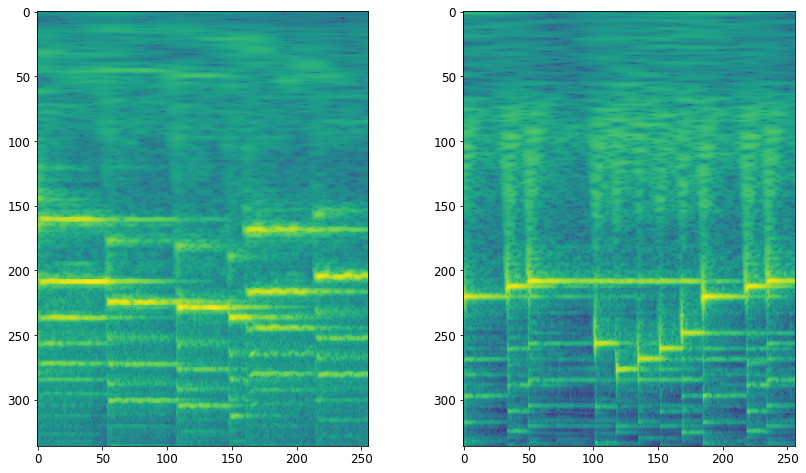

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/librosa/core/constantq.py:674: UserWarning: hop_length=256 exceeds minimum CQT filter length=213.284.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  "frequency resolution of your CQT.".format(hop_length, min(lengths))
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/librosa/core/constantq.py:674: UserWarning: hop_length=256 exceeds minimum CQT filter length=213.284.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  "frequency resolution of your CQT.".format(hop_length, min(lengths))


In [26]:
cqtSampleLength = int(sr*numSecondsPerChunk/hopLength)

# log abs CQT and phase
fluteCqtLogMag = np.log(np.abs(fluteCqt))
fluteCqtPhase = np.angle(fluteCqt)

pianoCqtLogMag = np.log(np.abs(pianoCqt))
pianoCqtPhase = np.angle(pianoCqt)

# standardization params
offsetFlute = centerOffset['flute'][STANDARDIZATION_STYLE]
offsetPiano = centerOffset['piano'][STANDARDIZATION_STYLE]
        
divFlute = divFactor['flute'][STANDARDIZATION_STYLE]
divPiano = divFactor['piano'][STANDARDIZATION_STYLE]

# normalize
fluteCqtLogMagNorm = (fluteCqtLogMag - offsetFlute) / divFlute
pianoCqtLogMagNorm = (pianoCqtLogMag - offsetPiano) / divPiano 


# set in evaluation mode
gen_F.eval()
gen_P.eval()

mpl.rcParams['figure.figsize'] = [14, 8]
mpl.rcParams['font.size'] = 12

with torch.no_grad():
    flute_img = torch.from_numpy(fluteCqtLogMagNorm[None, None, :, 0:cqtSampleLength]).to(DEVICE)
    piano_img = torch.from_numpy(pianoCqtLogMagNorm[None, None, :, 0:cqtSampleLength]).to(DEVICE)

    # generate fake piano and flute
    fake_flute, fake_piano = gen_F(piano_img).cpu().numpy(), gen_P(flute_img).cpu().numpy()
    
    # squeeze extra dims
    fake_flute, fake_piano = np.squeeze(fake_flute), np.squeeze(fake_piano)
    
    # un-normalize
    fake_flute = fake_flute * divFlute + offsetFlute
    fake_piano = fake_piano * divPiano + offsetPiano
    
    # plot to verify
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(fake_flute)
    ax[1].imshow(fake_piano)
    plt.show()
    plt.close(fig)
    
    # undo the log
    fake_flute, fake_piano = np.squeeze(np.exp(fake_flute)), np.squeeze(np.exp(fake_piano))
    
        
    # generate complex numbered values for generated CQT transforms
    generatedPianoCqt = fake_piano[:, 0:cqtSampleLength] * np.exp(1j*(fluteCqtPhase[:, 0:cqtSampleLength]))
    generatedFluteCqt = fake_flute[:, 0:cqtSampleLength] * np.exp(1j*(pianoCqtPhase[:, 0:cqtSampleLength]))
    
    generatedPianoWav = librosa.icqt(generatedPianoCqt, sr=sr, hop_length = hopLength, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)
    generatedFluteWav = librosa.icqt(generatedFluteCqt, sr=sr, hop_length = hopLength, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)
    
    generatedPianoWavFile = testOutputDir + '/debugPiano.wav'
    generatedFluteWavFile = testOutputDir + '/debugFlute.wav'
    
    sf.write(generatedPianoWavFile, generatedPianoWav, sr, subtype='PCM_24')
    sf.write(generatedFluteWavFile, generatedFluteWav, sr, subtype='PCM_24')
    
